# Plot ampl. modulace pro axialni EMM

In [9]:
# Setup some Jupyter env features
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# data import
#import pandas as pd
import numpy as np

#data_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_delim.txt", sep="\t").values
#voltages_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_voltages.txt", sep="\t").values

data_bezcond_p1 = np.genfromtxt("axial_EMM_10_03_2020_part1_delim.txt", delimiter="\t")[:,:8]
voltages_bezcond_p1 = np.genfromtxt("axial_EMM_10_03_2020_part1_voltages.txt", delimiter="\t")
data_bezcond_p2 = np.genfromtxt("axial_EMM_10_03_2020_part2_delim.txt", delimiter="\t")[:,:8]
voltages_bezcond_p2 = np.genfromtxt("axial_EMM_10_03_2020_part2_voltages.txt", delimiter="\t")
data_bezcond_p3 = np.genfromtxt("axial_EMM_10_03_2020_part3_delim.txt", delimiter="\t")[:,:2]
voltages_bezcond_p3 = np.genfromtxt("axial_EMM_10_03_2020_part3_voltages.txt", delimiter="\t")

fotkor_bezcond=np.concatenate( (data_bezcond_p1 ,data_bezcond_p2, data_bezcond_p3) ,axis=1)
voltages_bezcond=np.concatenate( (voltages_bezcond_p1 ,voltages_bezcond_p2, voltages_bezcond_p3) ,axis=0)

# pomocne promene
fotkor_shape = np.shape(fotkor_bezcond)

# parametry odecitani foton-korelacnich dat
t_res = 256e-12  # casove rozliseni histogramu v s
t_measure = 150 # doba nacitani dat v s

# casova skala foton-kor. dat
t_scale = np.array( range(0,fotkor_shape[0]) ) *t_res

In [11]:
# odhad periody triggeru
T_trig = ( fotkor_bezcond[fotkor_shape[0]-2, 9] / fotkor_bezcond[fotkor_shape[0]-3, 9] )* t_res + t_scale[fotkor_shape[0]-2]

T_trig_sigma = t_res
# frekvence buzeni pasti

drive_freq = 1/T_trig
drive_freq_sigma = 1/T_trig**2 *T_trig_sigma
Omega = 2*np.pi * drive_freq
Omega_sigma = 2*np.pi * drive_freq_sigma
drive_freq

30032035.976450287

In [12]:
# residua vcetne vah
# funkce vracejici residua
def fit_resid_weight(x,W_vec, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    # W_vec .. vektor vah prislusejicich jednotlivym bodum
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) - x[2])
    return( np.sqrt(W_vec) * (S - S_fit) )

def fit_func(x, Omega, time_points):
    return x[0] + x[1] * np.cos(Omega * time_points - x[2])

Nafitovani histogramu, vcetne vah

In [13]:
from scipy.optimize import least_squares
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
sigmas = np.zeros((3,fotkor_shape[1]))
Delta_S_S_ratio_sigma = []

hist_sigma = 80  # empiricky odhadnuto --- muze se zmenit
W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)
#W_vec = 1/30**2 * np.ones(fotkor_shape[0]-2)
for i in range(fotkor_shape[1]):
    x0 = [fotkor_bezcond[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,i].max()
        -fotkor_bezcond[:fotkor_shape[0]-2,i].min() ), 1.5]
#     W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)

    #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
    fit = least_squares(fit_resid_weight,x0, args=(W_vec,Omega, fotkor_bezcond[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)
    
    #---- odhad nejistot parametru----
    jac = fit.jac
    C = np.linalg.inv( np.matmul( np.transpose(jac), np.matmul( np.diag(W_vec), jac ) ) )  # variancni-kovariancni matice
    resid_sq = fit.fun**2   # residua na druhou
    g_fit = resid_sq.sum() * 1/( len(W_vec) - 3)   # goodnes of fit
    #-------------------------------
    
    
    x[:,i] = fit.x
    sigmas[:,i] = np.sqrt( np.diagonal(C) )
    DeltaS_S_ratio.append(x[1,i]/x[0,i]  )
    
    #---- sigma delta s ku s
    S0 = fit.x[0]
    DeltaS = fit.x[1]
    Delta_S_S_ratio_sigma.append(np.sqrt( 1/S0**2 * C[0,0] + (DeltaS**2 / S0**4)*C[1,1] -2*(DeltaS/S0**3)*C[0,1]) )

zkouska plotu

In [14]:
alpha_bezcond = (voltages_bezcond[:,0] - voltages_bezcond[:,1]) / (voltages_bezcond[:,0] + voltages_bezcond[:,1])
a = 0.000357087248516796
b = 0.0000614272209845667
c = 0.000214572720416111

z_bezcond = a* alpha_bezcond + b* alpha_bezcond**3 + c *alpha_bezcond**5

In [15]:
# plot dat
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rcParams["font.size"] = 14
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"
rcParams["text.usetex"] = "true";
rc('text', usetex=True)

No handles with labels found to put in legend.


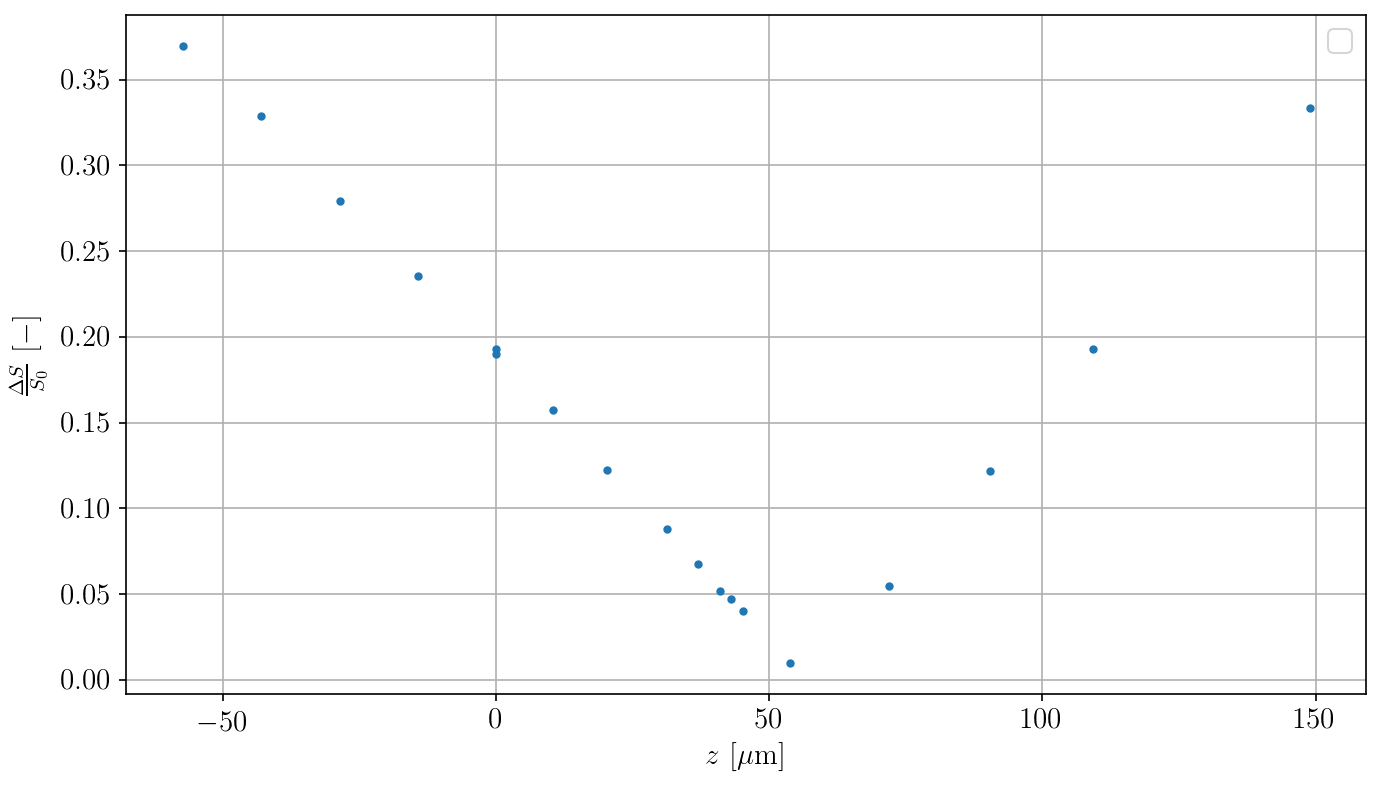

In [17]:
my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz

plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.plot(z_bezcond*1e6, np.abs(DeltaS_S_ratio), '.')
# plt.errorbar(z_bezcond*1e6, np.abs(DeltaS_S_ratio), yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
#plt.errorbar(z_bezcond*1e6, DeltaS_S_ratio, yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
plt.xlabel(r"$ z \, \, \rm [\mu m]$")
plt.ylabel(r"$ \frac{\Delta S}{S_0} \, \, \rm [-]$")

plt.legend()
plt.grid()

zavislost nafituju primkou

In [19]:
# fce vracejici residua

def MM_resid(x, beta, z_points):
    return( beta - x[0] - x[1]*z_points )

def MM_line(x, z):
    return(x[0] + x[1]*z)

In [20]:
# fit zavislosti deltaS/S (z)

x0 = [0.06, -0.1]


fit = least_squares(MM_resid,x0, args=(DeltaS_S_ratio, z_bezcond) , ftol=1e-10, xtol=1e-10)
linfit_bezcond = fit.x


fit

 active_mask: array([0., 0.])
        cost: 0.0003906583343877473
         fun: array([ 0.00495387,  0.00201221,  0.00478648,  0.00308368,  0.00649621,
        0.00601664,  0.00378271,  0.00566131,  0.00610968,  0.00519681,
        0.00261248, -0.00120104, -0.00795326, -0.01329749, -0.00168044,
       -0.00646478, -0.00581829, -0.01429677])
        grad: array([-2.86423267e-10,  9.31484180e-14])
         jac: array([[-1.00000000e+00, -0.00000000e+00],
       [-1.00000000e+00, -0.00000000e+00],
       [-1.00000000e+00, -1.04021217e-05],
       [-1.00000000e+00, -2.02237509e-05],
       [-1.00000000e+00, -3.12438719e-05],
       [-1.00000000e+00, -3.70106059e-05],
       [-1.00000000e+00, -4.09569749e-05],
       [-1.00000000e+00, -4.29619552e-05],
       [-1.00000000e+00, -4.51226848e-05],
       [-1.00000000e+00, -5.37866985e-05],
       [-1.00000000e+00, -7.19775306e-05],
       [-1.00000000e+00, -9.04411561e-05],
       [-1.00000000e+00, -1.09306122e-04],
       [-1.00000000e+00, -1.

In [22]:
# ocekavany nulovy MM
z_fit = np.linspace(z_bezcond.min(), z_bezcond.max(), 200)
DeltaS_S_fit = MM_line(linfit_bezcond, z_fit)

z_MM_zero = - linfit_bezcond[0]/linfit_bezcond[1]  # expected MM zero
print("z_EMM_zero = ", z_MM_zero*1e6)

z_EMM_zero =  55.117072962663315


Mrknu jak to vypada

No handles with labels found to put in legend.


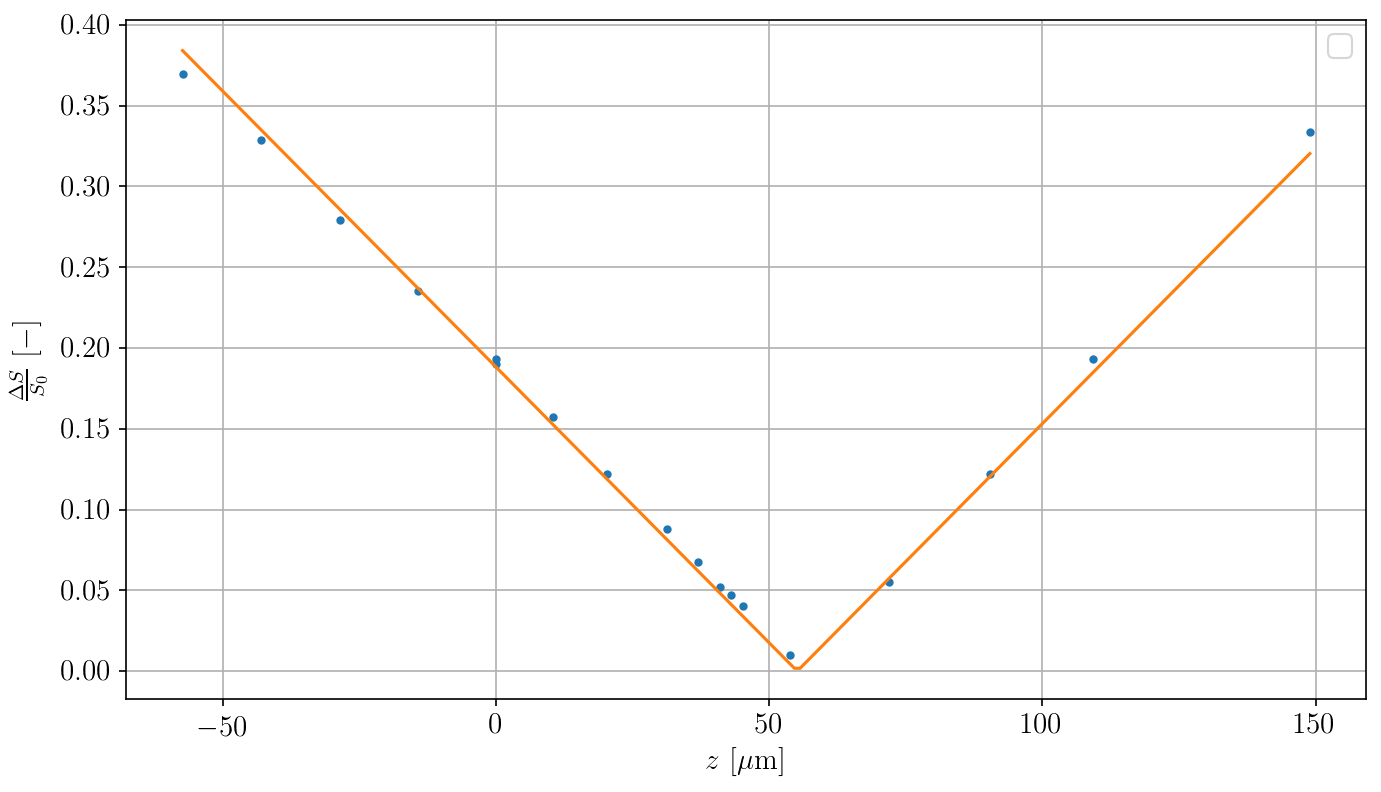

In [24]:
my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz

plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.plot(z_bezcond*1e6, np.abs(DeltaS_S_ratio), '.')
plt.plot(z_fit*1e6, np.abs(DeltaS_S_fit) )
# plt.errorbar(z_bezcond*1e6, np.abs(DeltaS_S_ratio), yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
#plt.errorbar(z_bezcond*1e6, DeltaS_S_ratio, yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
plt.xlabel(r"$ z \, \, \rm [\mu m]$")
plt.ylabel(r"$ \frac{\Delta S}{S_0} \, \, \rm [-]$")

plt.legend()
plt.grid()